In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
from tqdm import tqdm_notebook as tqdm
from torchvision.utils import save_image, make_grid
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import numpy as np
from IPython import display
import requests
from io import BytesIO
from PIL import Image
from PIL import Image, ImageSequence
from IPython.display import HTML
import warnings
from matplotlib import rc
import gc
import matplotlib
import sys
sys.path.append('../')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gc.enable()
plt.ioff()

In [2]:
from wolf.data.image import load_celeba_hair

In [3]:
trainset, testset = load_celeba_hair('../experiments/data/celeba_data/', 256)

The number of extraction is 1000


In [4]:
num_classes = 4
resnet = resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(3,64,3,stride=1,padding=1)
resnet_ = list(resnet.children())[:-2]
resnet_[3] = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
classifier = nn.Conv2d(512,num_classes,1)
torch.nn.init.kaiming_normal_(classifier.weight)
resnet_.append(classifier)
resnet_.append(nn.Upsample(size=256, mode='bilinear', align_corners=False))
tiny_resnet = nn.Sequential(*resnet_)

In [5]:
def attention(x):
    return torch.sigmoid(torch.logsumexp(x,1, keepdim=True))

In [6]:
train_iter = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)
test_iter = DataLoader(testset, batch_size=50, shuffle=False, num_workers=16, pin_memory=True)

classes = ('Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair')

In [7]:
len(train_iter)

200

In [8]:
len(trainset)

800

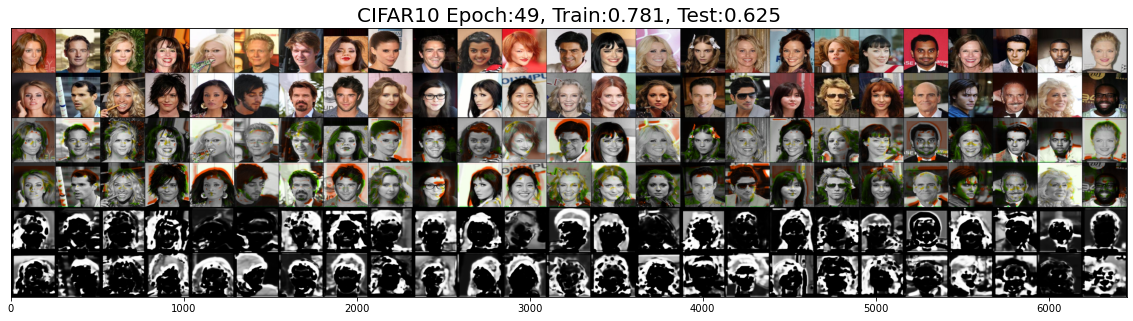

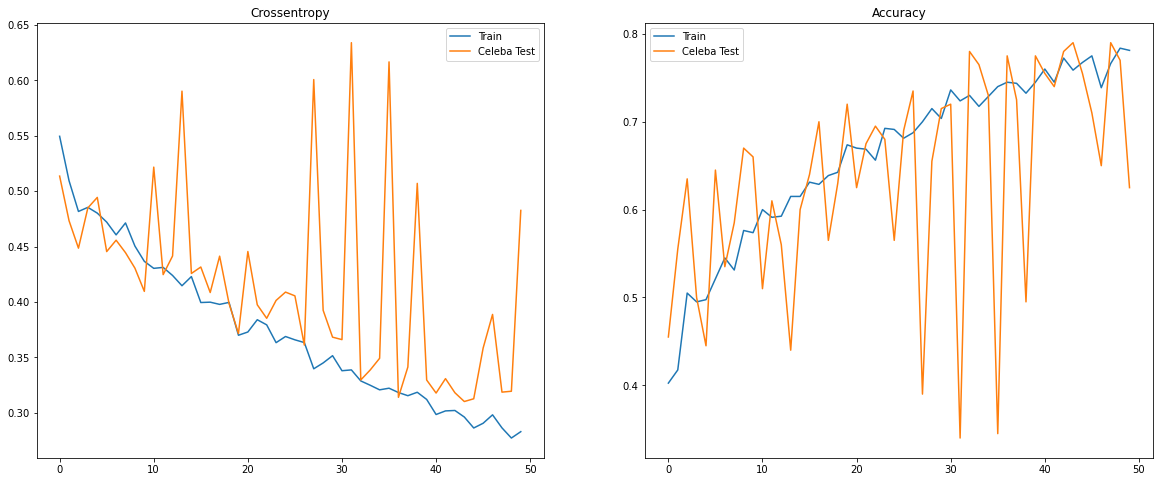

In [9]:
model = nn.DataParallel(tiny_resnet, device_ids=[0,1,2]).cuda()
# model.to(f'cuda:{model.device_ids[0]}')
# model = tiny_resnet.cuda()
# model = nn.DataParallel(tiny_resnet).cuda()
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,78,eta_min=0.001)

losses = []
acces = []
v_losses = []
v_acces = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    acc = 0.0
    var = 0.0
    model.train()
    train_pbar = train_iter
    for i, (x, _label) in tqdm(enumerate(train_pbar), desc='Train Epoch {}'.format(epoch), total=(800//4)):
        x = x.cuda()
        _label = _label.cuda()
        # (batch_size, num_class)
        label = F.one_hot(_label, num_classes=4).float()
        # (batch_size, num_class, h, w)
        seg_out = model(x)
        # (batch_size, 1, h, w)
        attn = attention(seg_out)
        # Smooth Max Aggregation
        # (batch_size, num_class)
        logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
        
        loss = criterion(logit, label)
        # loss = criterion(logit, _label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        epoch_loss += loss.item()
        acc += (logit.argmax(-1)==_label).sum()
        #train_pbar.set_description('Accuracy: {:.3f}%'.format(100*(logit.argmax(-1)==_label).float().mean()))
        
    avg_loss = epoch_loss / (i + 1)
    losses.append(avg_loss)
    avg_acc = acc.cpu().detach().numpy() / (len(trainset))
    acces.append(avg_acc)
    
    epoch_loss = 0.0
    acc = 0.0
    num_seen = 0
    
    model.eval()
    with torch.no_grad():
        test_pbar = tqdm(test_iter)
        for i, (x, _label) in tqdm(enumerate(test_pbar), desc='Test Epoch {}'.format(epoch), total=100):
            x = x.cuda()
            _label = _label.cuda()
            label = F.one_hot(_label, num_classes=4).float()
            seg_out = model(x)
            attn = attention(seg_out)
            logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
            loss = criterion(logit, label)
            # loss = criterion(logit, _label)
            epoch_loss += loss.item()
            acc += (logit.argmax(-1)==_label).sum()
            num_seen += label.size(0)
            test_pbar.set_description('Accuracy: {:.3f}%'.format(100*(acc.float()/num_seen)))
    
    avg_loss_val = epoch_loss / (i + 1)
    v_losses.append(avg_loss_val)
    avg_acc_val = acc.cpu().detach().numpy() / (len(testset))
    v_acces.append(avg_acc_val)
    plt.close('all')
    
    # seg_out shape: (batch_size, num_class, h, w)
    # conf = torch.max(nn.functional.softmax(seg_out, dim=1), dim=1)[0]
    # project to the max pixel
    hue = (torch.argmax(seg_out, dim=1).float() + 0.5)/10
    # x is the origin data, normalized to [0, 1]
    # x shape: (batch_size, 3, h, w)
    x -= x.min()
    x /= x.max()
    # (batch_size, h, w)
    gs_im = x.mean(1)
    gs_mean = gs_im.mean()
    gs_min = gs_im.min()
    gs_max = torch.max((gs_im-gs_min))
    gs_im = (gs_im - gs_min)/gs_max
    print('hue: ', hue.shape)
    print('attn: ', attn.shape)
    print('gs_im: ', gs_im.shape)
    hsv_im = torch.stack((hue.float(), attn.squeeze().float(), gs_im.float()), -1)
    im = hsv_to_rgb(hsv_im.cpu().detach().numpy())
    ex = make_grid(torch.tensor(im).permute(0,3,1,2), normalize=True, nrow=25)
    
    attns = make_grid(attn, normalize=False, nrow=25)
    attns = attns.cpu().detach()
    
    inputs = make_grid(x, normalize=True, nrow=25).cpu().detach()
    display.clear_output(wait=True)
    
    plt.figure(figsize=(20,8))
    plt.imshow(np.concatenate((inputs.numpy().transpose(1,2,0),ex.numpy().transpose(1,2,0), attns.numpy().transpose(1,2,0)), axis=0))
    #plt.xticks(np.linspace(18,324,10), classes)
    #plt.xticks(fontsize=20) 
    plt.yticks([])
    plt.title('CIFAR10 Epoch:{:02d}, Train:{:.3f}, Test:{:.3f}'.format(epoch, avg_acc, avg_acc_val), fontsize=20)
    display.display(plt.gcf())
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    ax[0].set_title('Crossentropy')
    ax[0].plot(losses, label='Train')
    ax[0].plot(v_losses, label='Celeba Test')
    ax[0].legend()
    ax[1].set_title('Accuracy')
    ax[1].plot(acces, label='Train')
    ax[1].plot(v_acces, label='Celeba Test')
    ax[1].legend()
    display.display(plt.gcf())